In [1]:
import os
import glob
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_unet_collection import models
from tensorflow import keras
from keras_unet_collection.utils import dummy_loader
import cv2
import gc

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
import os
from PIL import Image



# Path to data
SRC = 'cloth3d++_subset/'
print('SRC:', SRC)

N_TRAIN = 128
N_VAL = 16

n_epochs = 50
batch_size = 4

SRC: cloth3d++_subset/


In [2]:
class TFRecordDataHandler:
    def __init__(self, tfrecord_file, batch_size=32, shuffle=True, augment=False):
        self.tfrecord_file = tfrecord_file
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment

    def _parse_function(self, proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'depth': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth_height': tf.io.FixedLenFeature([], tf.int64),
            'depth_width': tf.io.FixedLenFeature([], tf.int64)
        }
        parsed_features = tf.io.parse_single_example(proto, feature_description)

        image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
        depth = tf.io.decode_raw(parsed_features['depth'], tf.float32)

        height = parsed_features['height']
        width = parsed_features['width']

        image = tf.reshape(image, [height, width, 3])
        depth = tf.reshape(depth, [parsed_features['depth_height'], parsed_features['depth_width']])

        return image, depth

    def _normalize(self, image, depth):
        # Convert image to float for processing and normalize to range [0, 1]
        image = tf.cast(image, tf.float32) / 255.0

        # Create a mask where depth values are greater than zero
        depth_mask = depth > 0

        # Normalize depth based on masked regions
        # Calculate the mean of the depth where it is greater than zero
        depth_values = tf.boolean_mask(depth, depth_mask)
        depth_mean = tf.reduce_mean(depth_values)

        # Subtract the mean from the depth values where mask is true
        depth = tf.where(depth_mask, depth - depth_mean, depth)

        # Set depth values less than 0 to 0 after subtraction
        depth = tf.maximum(depth, 0)

        # Prepare the mask for RGB image normalization
        mask = tf.tile(tf.expand_dims(depth_mask, axis=-1), [1, 1, 3])

        # Masked image for mean and std deviation calculation
        masked_image = tf.boolean_mask(image, mask)
        mean, variance = tf.nn.moments(masked_image, axes=[0])
        std_dev = tf.sqrt(variance + 1e-6)  # Adding epsilon to avoid division by zero

        # Apply the mask to image normalization
        normalized_image = tf.where(
            mask,
            (image - mean) / std_dev,
            image  # Preserve original pixels where mask is False
        )

        return normalized_image, depth

    def _augment(self, image, depth):
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            depth = tf.image.flip_left_right(tf.expand_dims(depth, axis=-1))
            depth = tf.squeeze(depth, axis=-1)
        image = tf.image.random_brightness(image, max_delta=0.1)
        return image, depth

    def load_dataset(self):
        dataset = tf.data.TFRecordDataset(self.tfrecord_file)
        dataset = dataset.map(self._parse_function, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(self._normalize, num_parallel_calls=tf.data.AUTOTUNE)

        if self.augment:
            dataset = dataset.map(self._augment, num_parallel_calls=tf.data.AUTOTUNE)

        if self.shuffle:
            dataset = dataset.shuffle(buffer_size=1000)

        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset


In [3]:

class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        print(f"Epoch {epoch + 1}: Learning rate is {tf.keras.backend.get_value(lr):.6f}")

class TensorBoardLearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir='./logs'):
        super(TensorBoardLearningRateLogger, self).__init__()
        self.file_writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        with self.file_writer.as_default():
            tf.summary.scalar('learning_rate', tf.keras.backend.get_value(lr), step=epoch)

In [4]:
def visualize_hist(history, show=True, filename=None, title='Training history'):
    train_hist = history.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    ax1.plot(train_hist['loss'])
    ax1.plot(train_hist['val_loss'])
    ax1.set(xlabel='epoch', ylabel='Loss')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_hist['mae'])
    ax2.plot(train_hist['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')

    if show:
        plt.show()

    if filename is not None:
        fig.savefig(filename)


In [5]:
class WarmUpCosineDecayScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, target_learning_rate, total_steps, warmup_steps):
        super(WarmUpCosineDecayScheduler, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.target_learning_rate = target_learning_rate
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.decay_steps = total_steps - warmup_steps

    def __call__(self, step):
        # Convert to float32 to ensure the operations are compatible
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        decay_steps = tf.cast(self.decay_steps, tf.float32)

        # Compute the warmup learning rate
        warmup_lr = self.initial_learning_rate + (self.target_learning_rate - self.initial_learning_rate) * (step / warmup_steps)

        # Compute the cosine decay learning rate
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * (step - warmup_steps) / decay_steps))
        decayed_lr = (self.target_learning_rate - self.initial_learning_rate) * cosine_decay + self.initial_learning_rate

        # Choose the learning rate based on the step
        learning_rate = tf.where(step < warmup_steps, warmup_lr, decayed_lr)
        return learning_rate

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'target_learning_rate': self.target_learning_rate,
            'total_steps': self.total_steps,
            'warmup_steps': self.warmup_steps
        }

Number of data used to train:
372

Input shape: (4, 256, 256, 3)
Label shape: (4, 256, 256)
Learning rate: 1e-05
Epoch 1/50
93/93 [==============================] - 80s 670ms/step - loss: 0.0646 - mae: 0.1922 - val_loss: 0.9081 - val_mae: 0.9399
Epoch 2/50
93/93 [==============================] - 61s 655ms/step - loss: 0.0157 - mae: 0.0787 - val_loss: 0.0269 - val_mae: 0.0637
Epoch 3/50
93/93 [==============================] - 61s 655ms/step - loss: 0.0087 - mae: 0.0486 - val_loss: 0.0212 - val_mae: 0.0553
Epoch 4/50
93/93 [==============================] - 61s 655ms/step - loss: 0.0081 - mae: 0.0433 - val_loss: 0.0247 - val_mae: 0.0565
Epoch 5/50
93/93 [==============================] - 61s 654ms/step - loss: 0.0070 - mae: 0.0373 - val_loss: 0.0106 - val_mae: 0.0399
Epoch 6/50
93/93 [==============================] - 61s 657ms/step - loss: 0.0067 - mae: 0.0342 - val_loss: 0.0094 - val_mae: 0.0383
Epoch 7/50
93/93 [==============================] - 61s 654ms/step - loss: 0.0067 - mae: 

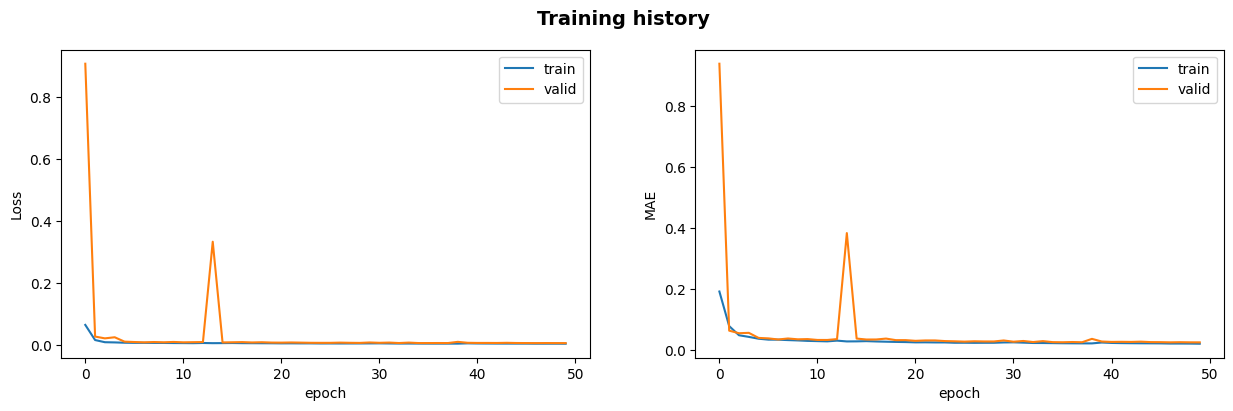

Best validation loss: 0.005832240916788578 at epoch 49


: 

In [6]:
# Parameters
initial_learning_rate = 1e-5
target_learning_rate = 1e-2
verbose = 1
shuffle = True
checkpoint = './best_model.h5'



train_dg = TFRecordDataHandler('train.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=True).load_dataset()
validation_dg = TFRecordDataHandler('validation.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=False).load_dataset()
print('Number of data used to train:')
print(len(list(train_dg))* batch_size)
print('')

for x, y in train_dg.take(1):
    print("Input shape:", x.shape)  # Should be (batch_size, height, width, channels)
    print("Label shape:", y.shape)  # Should be (batch_size, ...) depending on your task


total_steps = len(list(train_dg)) * n_epochs


for wu_ratio in [0.1]:

    warmup_steps = int(wu_ratio * total_steps)

    experiment_name = f'lr_decay_{initial_learning_rate}_{target_learning_rate}_wu_ratio_{wu_ratio}_transunet_2d_bs_{batch_size}'

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('./logs_TransUnet', experiment_name))


    # Create the learning rate schedule
    lr_schedule = WarmUpCosineDecayScheduler(
        initial_learning_rate=initial_learning_rate,
        target_learning_rate=target_learning_rate,
        total_steps=total_steps,
        warmup_steps=warmup_steps
    )

    # Define the optimizer with the custom learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


    model = models.transunet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=1,
                            stack_num_down=2, stack_num_up=1,
                            activation='GELU', output_activation='Sigmoid',
                            batch_norm=True, pool='max', unpool=False, name='transunet_2d', embed_dim=100, num_heads=4)

    print('Learning rate:', initial_learning_rate)
    # defining the optimizer
    model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    # es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

    # saving the best model based on val_loss
    # mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

    # training the model and saving the history
    history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, workers=4, use_multiprocessing=True,
                        callbacks=[tensorboard_callback])

    # Plot and write the history
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    filename = os.path.join(experiment_name, 'train_history.jpg')
    visualize_hist(history, show=True, filename=filename)

    #with open('train_history_lr_'+str(lr)+'.pkl', 'wb') as handle:
    #    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Get the best validation loss and the epoch

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss)
    # d_lr[lr] = (best_val_loss, best_epoch)
    print('Best validation loss:', best_val_loss, 'at epoch', best_epoch)

    # Clear gpu memory
    del model
    gc.collect()
    tf.keras.backend.clear_session()

In [ ]:
# Parameters
initial_learning_rate = 1e-5
target_learning_rate = 1e-2
verbose = 1
shuffle = True
checkpoint = './best_model.h5'



train_dg = TFRecordDataHandler('train.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=True).load_dataset()
validation_dg = TFRecordDataHandler('validation.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=False).load_dataset()
print('Number of data used to train:')
print(len(list(train_dg))* batch_size)
print('')

for x, y in train_dg.take(1):
    print("Input shape:", x.shape)  # Should be (batch_size, height, width, channels)
    print("Label shape:", y.shape)  # Should be (batch_size, ...) depending on your task


total_steps = len(list(train_dg)) * n_epochs


for wu_ratio in [0.1]:

    warmup_steps = int(wu_ratio * total_steps)

    experiment_name = f'/lr_decay_{initial_learning_rate}_{target_learning_rate}_wu_ratio_{wu_ratio}_transunet_2d_max_embed_dim'

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(experiment_name, 'TensorBoard'))
    tensorboard_lr_logger = TensorBoardLearningRateLogger(os.path.join(experiment_name, 'TensorBoard'))


    # Create the learning rate schedule
    lr_schedule = WarmUpCosineDecayScheduler(
        initial_learning_rate=initial_learning_rate,
        target_learning_rate=target_learning_rate,
        total_steps=total_steps,
        warmup_steps=warmup_steps
    )

    # Define the optimizer with the custom learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


    model = models.transunet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=1,
                            stack_num_down=2, stack_num_up=1,
                            activation='GELU', output_activation='Sigmoid',
                            batch_norm=True, pool='max', unpool=False, name='transunet_2d', num_heads=4)

    print('Learning rate:', initial_learning_rate)
    # defining the optimizer
    model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    # es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

    # saving the best model based on val_loss
    # mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

    # training the model and saving the history
    history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, workers=2, use_multiprocessing=True,
callbacks=[tensorboard_callback]
                        )

    # Plot and write the history
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    filename = os.path.join(experiment_name, 'train_history.jpg')
    visualize_hist(history, show=True, filename=filename)

    #with open('train_history_lr_'+str(lr)+'.pkl', 'wb') as handle:
    #    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Get the best validation loss and the epoch

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss)
    # d_lr[lr] = (best_val_loss, best_epoch)
    print('Best validation loss:', best_val_loss, 'at epoch', best_epoch)

    # Clear gpu memory
    del model
    gc.collect()
    tf.keras.backend.clear_session()

Number of data used to train:
372

Input shape: (4, 256, 256, 3)
Label shape: (4, 256, 256)
Learning rate: 1e-05
Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'transunet_2d_model/transunet_2d_ViT_6_mlp_dense_1/Tensordot/MatMul' defined at (most recent call last):
    File "c:\Users\xavie\miniconda3\envs\or\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\xavie\miniconda3\envs\or\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\xavie\miniconda3\envs\or\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\xavie\miniconda3\envs\or\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\xavie\miniconda3\envs\or\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\xavie\AppData\Local\Temp\ipykernel_27528\1070447381.py", line 61, in <module>
      history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, workers=2, use_multiprocessing=True,
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xavie\miniconda3\envs\or\lib\site-packages\keras\layers\core\dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'transunet_2d_model/transunet_2d_ViT_6_mlp_dense_1/Tensordot/MatMul'
OOM when allocating tensor with shape[1024,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node transunet_2d_model/transunet_2d_ViT_6_mlp_dense_1/Tensordot/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_68210]